In [ ]:
import os
import sys
import numpy as np
import open3d as o3d

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

from utils.config import Config
from utils.data import RGBDDataset, FrameData
from utils.vis import Visualizer
from utils.depth import correct_depth, clip_depth
from utils.pcd import create_pcd_from_rgbd, clip_radially

data_path = os.path.join(current_dir, Config.DATA_PATH)
dataset = RGBDDataset(data_path)
vis = Visualizer()

# for run_03_syn
# entrance to the weld section, frame: 195 + 15 
# weld section frame: 285 + 30
# exiting the weld section, frame: 345 + 15
# rolled section, frame: 345 + 360

start_frame = 345
frame_count = 15

poses = []
global_pcd = o3d.geometry.PointCloud()
for i in range(frame_count):
    frame_idx = start_frame + i
    frame: FrameData = dataset[frame_idx] # type: ignore
    color = frame['color']
    depth = frame['depth_raw']
    corrected_depth, _ = correct_depth(depth)
    clipped_depth = clip_depth(corrected_depth, 225.0, 325.0)
    pcd = create_pcd_from_rgbd(clipped_depth, color)
    radially_clipped_pcd = clip_radially(pcd)
    pose = np.eye(4)
    z = 0.3 * - i
    pose[2, 3] = z
    poses.append(pose)
    radially_clipped_pcd.transform(pose)
    global_pcd += radially_clipped_pcd


vis.pointcloud(global_pcd)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


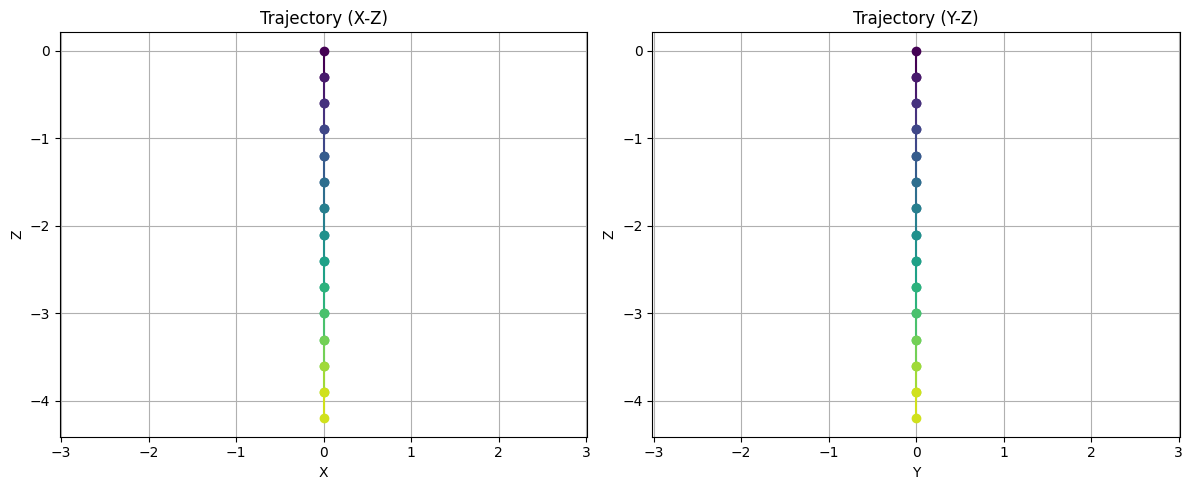

In [2]:
import matplotlib.pyplot as plt
import numpy as np

poses = np.stack(poses, axis=0)  # Shape: (N, 4, 4)

xs = poses[:, 0, 3]
ys = poses[:, 1, 3]
zs = poses[:, 2, 3]

N = len(xs)
colors = plt.get_cmap('viridis')(np.linspace(0, 1, N))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i in range(N - 1):
    plt.plot(xs[i:i+2], zs[i:i+2], color=colors[i], marker='o')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Trajectory (X-Z)')
plt.grid(True)
plt.axis('equal')

plt.subplot(1, 2, 2)
for i in range(N - 1):
    plt.plot(ys[i:i+2], zs[i:i+2], color=colors[i], marker='o')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Trajectory (Y-Z)')
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()